In [1]:
#ALGORITHM = 'XG Boost'
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'CatBoost'
ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: Light Gradient Boosting
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [2]:
%pip install catboost
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'local', 'use_gpu': False, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', LGBMRegressor())])

In [6]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [7]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [8]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [9]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [10]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [12]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [13]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [19]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower()=='light gradient boosting':
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00]
[[525000.]
 [225000.]
 [475000.]
 ...
 [435000.]
 [315000.]
 [600000.]] [525000. 225000. 475000. ... 435000. 315000. 600000.]
(39714, 11) (4413, 11) (39714,) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [20]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [21]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()

print("default_model_params:\n", default_model_params)
print("---------------------")
print("sklearn.metrics.get_scorer_names():\n",sklearn.metrics.get_scorer_names())

default_model_params:
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
---------------------
sklearn.metrics.get_scorer_names():
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentag

In [23]:
#jh
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)


if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower():
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)

if not_catboost and len(param_options.keys()) > 2 and not already_timed:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print('\n\nHyperparameters:')
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1


Hyperparameters:


{'model__boosting_type': ['gbdt'],
 'model__colsample_bytree': [0.6],
 'model__is_unbalance': [True, False],
 'model__learning_rate': [0.05],
 'model__metric': ['auc'],
 'model__min_child_samples': [20],
 'model__n_estimators': [64],
 'model__num_iterations': [25, 50],
 'model__num_leaves': [20],
 'model__verbose': [1]}

In [24]:
from catboost import CatBoostRegressor, Pool


def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971
Total fit/CV time      : 18 seconds   (1668606406.1031578 ==> 1668606424.9430032)

average fit/score time = 0.46s/0.09s
max fit/score time     = 0.69s/0.14s
refit time             = 1.78s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model', LGBMRegressor())]),
                   n_iter=100, n_jobs=3,
                   param_distributions={'model__boosting_type': ['gbdt'],
                                        'model__colsample_bytree': [0.6],
                                        'model__is_unbalance': [True, False],
                                        'model__learning_rate': [0.05],
                                        'model__metric': ['auc'],
                                        'model__min_child_samples': [20],
                                        'model__n_estimators': [64],
                                        'model__num_iterations': [25, 50],
                                        'model__num_leaves': [20],
                                        'model__verbose': [1]},
                   return_train_score=True, scoring='r2', verbose=1)

In [25]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [26]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

LGBMRegressor()


In [27]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [28]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__verbose,param_model__num_leaves,param_model__num_iterations,param_model__n_estimators,param_model__min_child_samples,param_model__metric,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.685734,0.024941,0.115772,0.020674,1,20,50,64,20,auc,...,0.563231,0.569517,0.566006,0.002619,1,0.575135,0.577204,0.571536,0.574625,0.002342
3,0.492596,0.040312,0.138417,0.017037,1,20,50,64,20,auc,...,0.563231,0.569517,0.566006,0.002619,1,0.575135,0.577204,0.571536,0.574625,0.002342
0,0.355816,0.018449,0.056949,0.013722,1,20,25,64,20,auc,...,0.464403,0.466681,0.465415,0.000947,3,0.471020,0.473846,0.468589,0.471152,0.002148
2,0.297511,0.028030,0.051027,0.004019,1,20,25,64,20,auc,...,0.464403,0.466681,0.465415,0.000947,3,0.471020,0.473846,0.468589,0.471152,0.002148


In [29]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [30]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [31]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/20/50/64/20/auc/0.05/True/0.6/gbdt,1,0.566006,0.685734,0.115772,"{'model__verbose': 1, 'model__num_leaves': 20,..."
1,1/20/50/64/20/auc/0.05/False/0.6/gbdt,1,0.566006,0.492596,0.138417,"{'model__verbose': 1, 'model__num_leaves': 20,..."
2,1/20/25/64/20/auc/0.05/True/0.6/gbdt,3,0.465415,0.355816,0.056949,"{'model__verbose': 1, 'model__num_leaves': 20,..."
3,1/20/25/64/20/auc/0.05/False/0.6/gbdt,3,0.465415,0.297511,0.051027,"{'model__verbose': 1, 'model__num_leaves': 20,..."


In [32]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/20/50/64/20/auc/0.05/True/0.6/gbdt,1,0.566006,0.685734,0.115772,"{'model__verbose': 1, 'model__num_leaves': 20,..."
1,1/20/50/64/20/auc/0.05/False/0.6/gbdt,1,0.566006,0.492596,0.138417,"{'model__verbose': 1, 'model__num_leaves': 20,..."
2,1/20/25/64/20/auc/0.05/True/0.6/gbdt,3,0.465415,0.355816,0.056949,"{'model__verbose': 1, 'model__num_leaves': 20,..."
3,1/20/25/64/20/auc/0.05/False/0.6/gbdt,3,0.465415,0.297511,0.051027,"{'model__verbose': 1, 'model__num_leaves': 20,..."


In [33]:
#pd.set_option('display.max_columns', None)


In [34]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_model__verbose,param_model__num_leaves,param_model__num_iterations,param_model__n_estimators,param_model__min_child_samples,param_model__metric,param_model__learning_rate,param_model__is_unbalance,param_model__colsample_bytree,param_model__boosting_type,params,params2
1,1,0.566006,0.685734,0.115772,1,20,50,64,20,auc,0.05,True,0.6,gbdt,"{'model__verbose': 1, 'model__num_leaves': 20,...",1/20/50/64/20/auc/0.05/True/0.6/gbdt
3,1,0.566006,0.492596,0.138417,1,20,50,64,20,auc,0.05,False,0.6,gbdt,"{'model__verbose': 1, 'model__num_leaves': 20,...",1/20/50/64/20/auc/0.05/False/0.6/gbdt
0,3,0.465415,0.355816,0.056949,1,20,25,64,20,auc,0.05,True,0.6,gbdt,"{'model__verbose': 1, 'model__num_leaves': 20,...",1/20/25/64/20/auc/0.05/True/0.6/gbdt
2,3,0.465415,0.297511,0.051027,1,20,25,64,20,auc,0.05,False,0.6,gbdt,"{'model__verbose': 1, 'model__num_leaves': 20,...",1/20/25/64/20/auc/0.05/False/0.6/gbdt


In [35]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [36]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [37]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

Best Index:  1
Best Score:  0.5660063354375875
Best Params:  {'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 50, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.05, 'model__is_unbalance': True, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'gbdt'}


In [38]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([ 1.000000e+00,  1.000000e+00,  6.959676e-01,  5.147824e+01,
       -8.707000e-02,  2.148000e-02,  1.735000e-02,  0.000000e+00,
        0.000000e+00,  1.000000e+00,  0.000000e+00])

In [39]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [40]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.5782182084315399

In [41]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Light Gradient Boosting----------
R square Accuracy 0.5782182084315399
Mean Absolute Error Accuracy 56113.3570084384
Mean Squared Error Accuracy 4764618204.403697
Root Mean Squared Error 69026.21389301095


In [42]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [43]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,390734.903657,9265.096343,2.316274,2.371198
119328242,369950.0,401196.535517,31246.535517,8.446151,7.788336
125716790,350000.0,410965.337676,60965.337676,17.418668,14.834667
122440040,549000.0,483552.458389,65447.541611,11.921228,13.534735
120508103,495000.0,475449.466974,19550.533026,3.949603,4.112011
...,...,...,...,...,...
68620869,475000.0,517730.889583,42730.889583,8.995977,8.253494
85735665,575000.0,525521.089562,49478.910438,8.605028,9.415209
125706338,400000.0,415561.314536,15561.314536,3.890329,3.744649


In [44]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,495875,335875.870110,209.922419,67.733860,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
109722224,108000,327830,219830.184003,203.546467,67.056115,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,122000,358238,236238.117983,193.637802,65.944439,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
83639617,190000,445031,255031.613119,134.227165,57.306404,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
122821142,170000,377958,207958.924735,122.328779,55.021567,170000,2,1,0.093936,51.430690,0.024020,0.069030,0.128440,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120288737,450000,450198,198.536421,0.044119,0.044100,450000,3,1,0.290369,51.475666,-0.063100,0.024054,0.041320,LEASEHOLD
123001337,430000,429850,149.090257,0.034672,0.034684,430000,2,1,0.171878,51.615248,-0.249778,0.115528,0.145358,SHARE_OF_FREEHOLD
120367307,475000,475103,103.505705,0.021791,0.021786,475000,2,2,0.134742,51.588859,-0.041390,0.089139,0.063030,LEASEHOLD
125825717,385000,384920,79.187154,0.020568,0.020572,385000,2,1,0.128405,51.412918,0.019234,0.086802,0.123654,LEASEHOLD


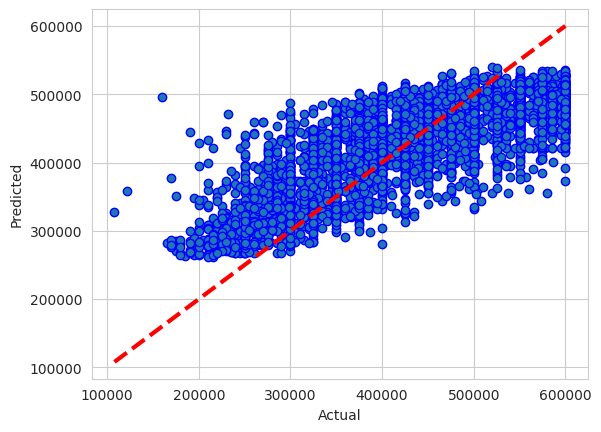

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [46]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
1 ==> 1
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 50, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.05, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'gbdt'}


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.356867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971
2 ==> 2
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 25, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.05, 'model__is_unbalance': True, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'gbdt'}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[Lig

/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


3 ==> 3
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 25, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.05, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'gbdt'}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-1 ==> -1
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 25, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.05, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'gbdt'}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [47]:
cv_results_df_sorted if not_catboost else ''

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1/20/50/64/20/auc/0.05/True/0.6/gbdt,1,0.566006,0.685734,0.115772,"{'model__verbose': 1, 'model__num_leaves': 20,..."
1,1/20/50/64/20/auc/0.05/False/0.6/gbdt,1,0.566006,0.492596,0.138417,"{'model__verbose': 1, 'model__num_leaves': 20,..."
2,1/20/25/64/20/auc/0.05/True/0.6/gbdt,3,0.465415,0.355816,0.056949,"{'model__verbose': 1, 'model__num_leaves': 20,..."
3,1/20/25/64/20/auc/0.05/False/0.6/gbdt,3,0.465415,0.297511,0.051027,"{'model__verbose': 1, 'model__num_leaves': 20,..."


In [48]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [49]:
cv_results_df_sorted['params'][0] if not_catboost else ''

{'model__verbose': 1,
 'model__num_leaves': 20,
 'model__num_iterations': 50,
 'model__n_estimators': 64,
 'model__min_child_samples': 20,
 'model__metric': 'auc',
 'model__learning_rate': 0.05,
 'model__is_unbalance': True,
 'model__colsample_bytree': 0.6,
 'model__boosting_type': 'gbdt'}

In [50]:
best_models if not_catboost else ''

{0: {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 0.6,
  'importance_type': 'split',
  'learning_rate': 0.05,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 64,
  'n_jobs': -1,
  'num_leaves': 20,
  'objective': None,
  'random_state': None,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0,
  'verbose': 1,
  'num_iterations': 50,
  'metric': 'auc',
  'is_unbalance': True},
 1: {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 0.6,
  'importance_type': 'split',
  'learning_rate': 0.05,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 64,
  'n_jobs': -1,
  'num_leaves': 20,
  'objective': None,
  'random_state': None,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 1.0,
  'subsample_for_bin':

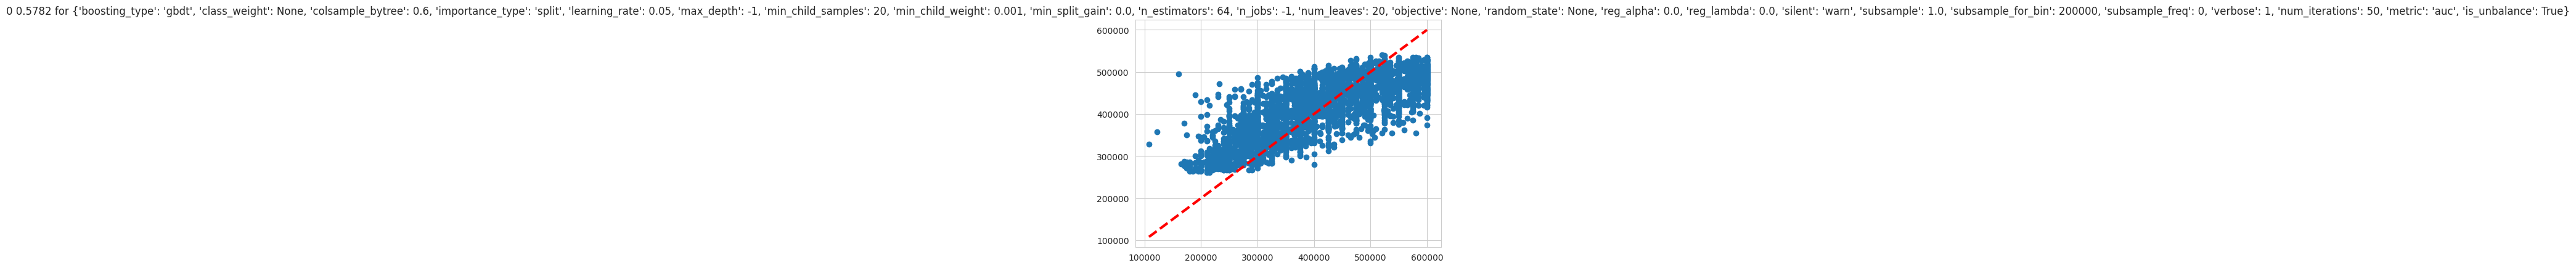

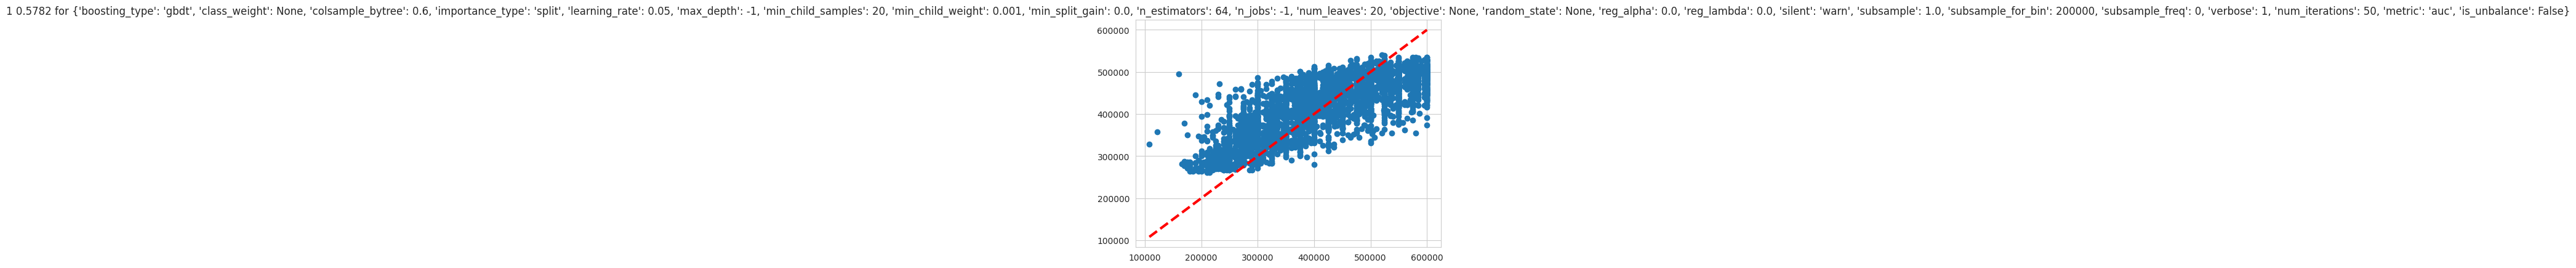

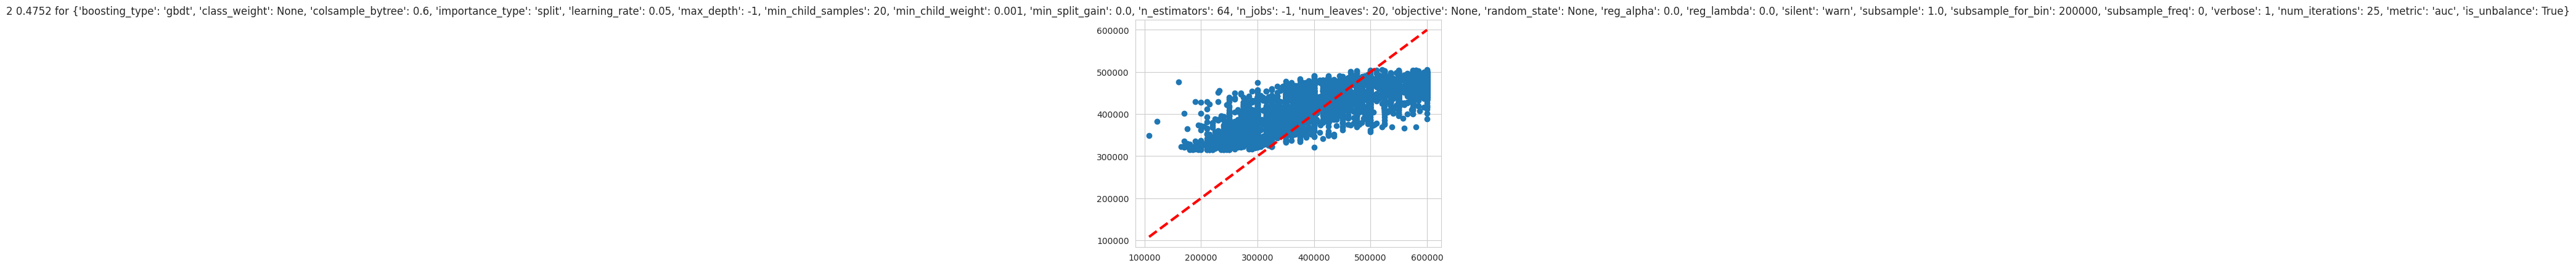

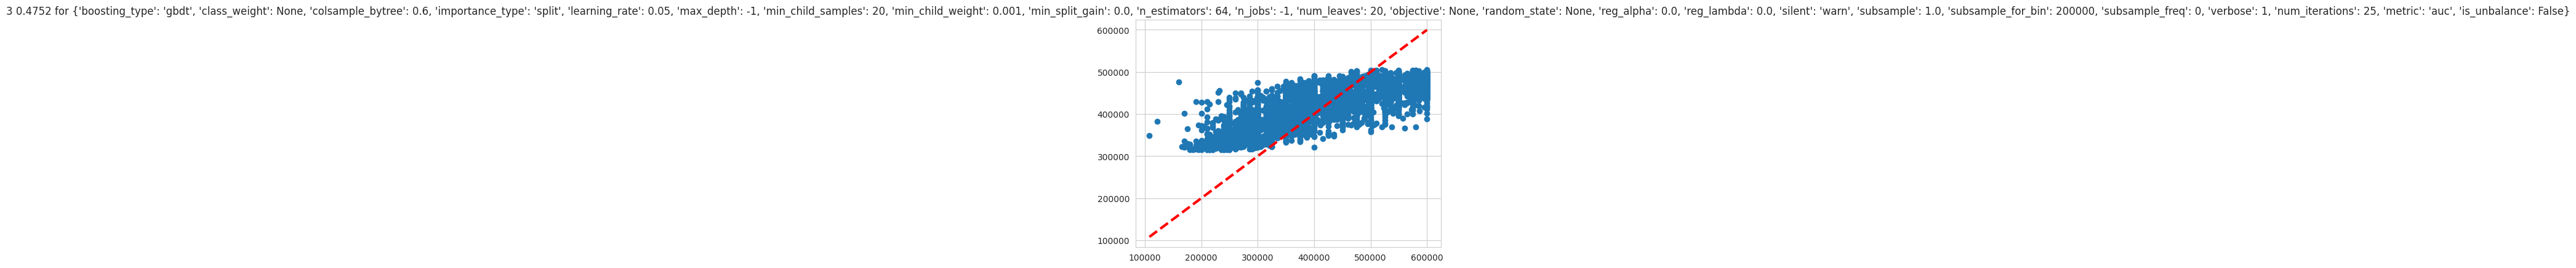

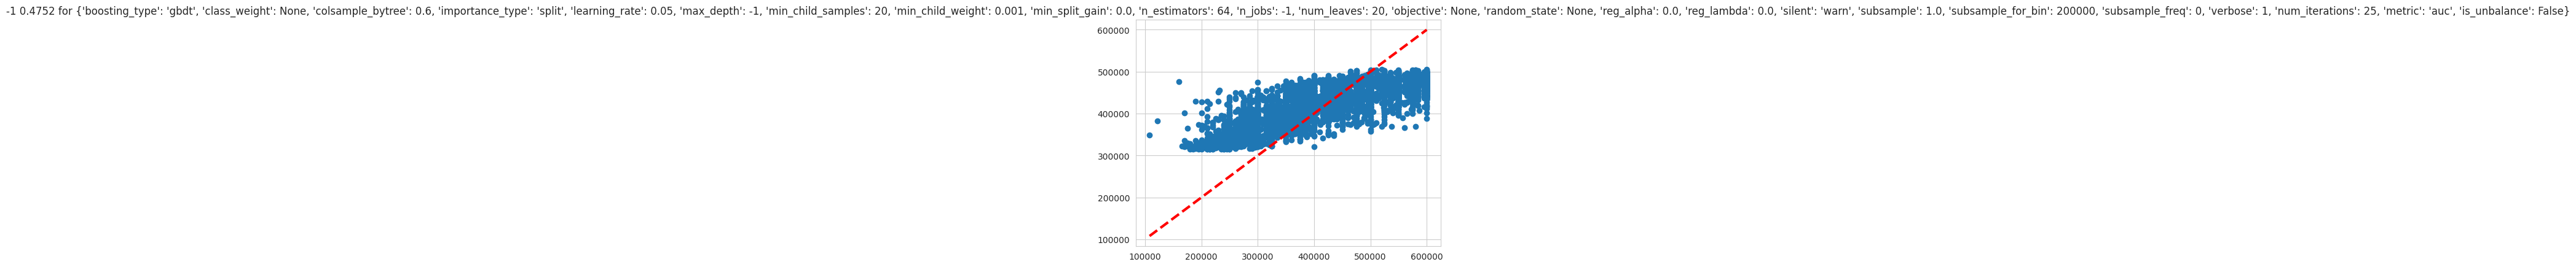

In [51]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

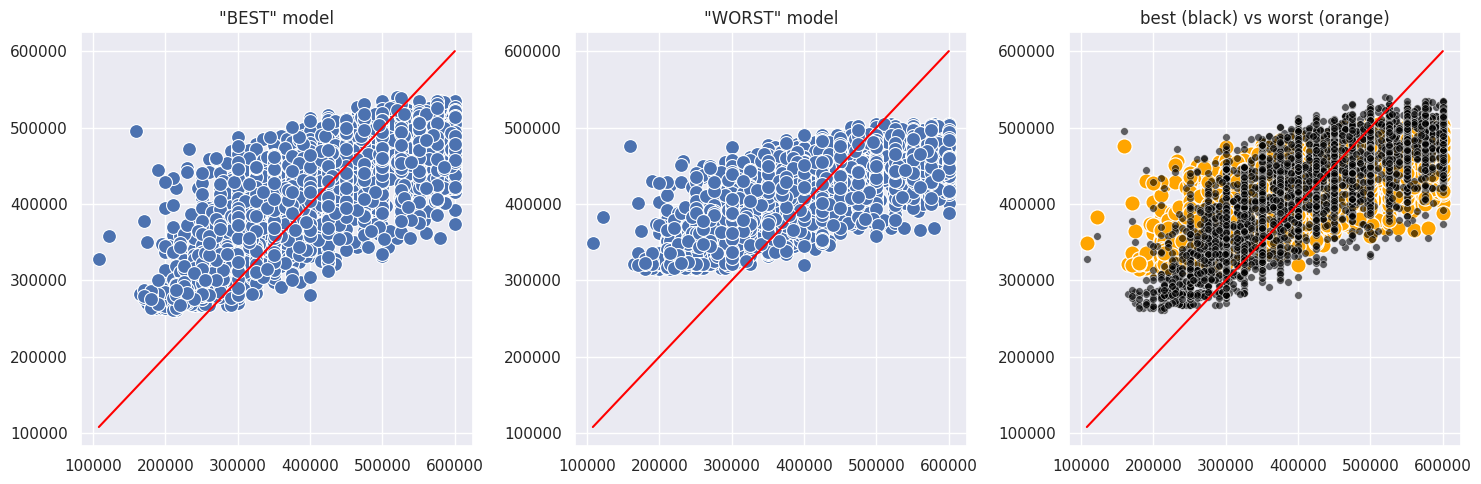

In [52]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [53]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

0.6857337951660156

In [55]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

haven't scored this model yet: Light Gradient Boosting
(debug:do nothing)
light gradient boosting (v06)


In [56]:
crossval_runner.best_estimator_  if not_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(colsample_bytree=0.6, is_unbalance=True,
                               learning_rate=0.05, metric='auc',
                               n_estimators=64, num_iterations=50,
                               num_leaves=20, verbose=1))])

In [57]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)

# 0.45687994672121157 jh

pickled new version of model
0.5782182084315399 is new best score (it's better than -999


In [58]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 4 (207.000000) location.longitude
2. features 3 (179.000000) location.latitude
3. features 5 (150.000000) latitude_deviation
4. features 6 (129.000000) longitude_deviation
5. features 0 (89.000000) bedrooms
6. features 2 (54.000000) nearestStation
7. features 1 (50.000000) bathrooms
8. features 8 (35.000000) tenure.tenureType_FREEHOLD
9. features 9 (31.000000) tenure.tenureType_LEASEHOLD
10. features 10 (26.000000) tenure.tenureType_SHARE_OF_FREEHOLD
11. features 7 (0.000000) tenure.tenureType_COMMONHOLD


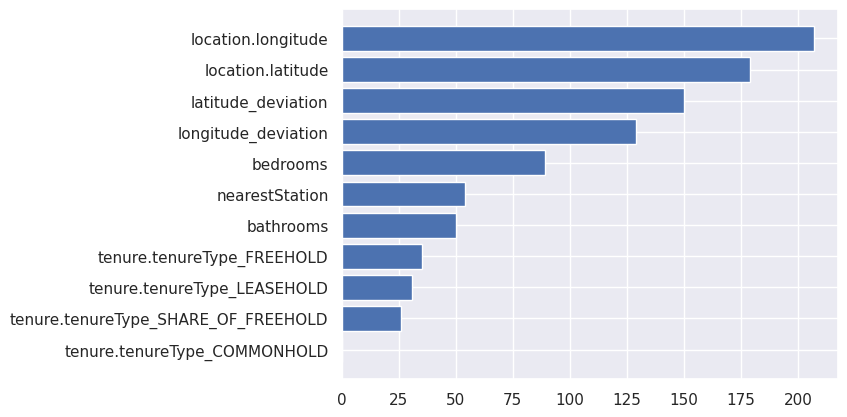

In [59]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')